In [ ]:
import os
import numpy as np
import cv2
import json

## sam3

In [4]:

MASK_DIR = "../output_sam/sam_masks_all"   # SAM mask 文件夹
OUTPUT_JSON = "../output_sam/sam_contours.json"
os.makedirs(os.path.dirname(OUTPUT_JSON), exist_ok=True)

mask_files = [f for f in os.listdir(MASK_DIR) if f.endswith(".npy")]

sam_dict = {}

for mask_file in mask_files:
    # 文件名解析
    base = mask_file.replace(".npy","")
    img_name = base.split("_mask")[0] + ".JPG"
    mask_id = int(base.split("_mask")[1])

    # 读取 mask
    mask = np.load(os.path.join(MASK_DIR, mask_file))  # bool 或 0/1
    mask_uint8 = (mask > 0).astype(np.uint8) * 255

    # 提取轮廓
    contours, hierarchy = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 保存轮廓为 list of points
    contours_list = []
    for c in contours:
        c_points = c.squeeze().tolist()  # Nx2 list
        if isinstance(c_points[0], list):  # 保证二维数组
            contours_list.append(c_points)

    if img_name not in sam_dict:
        sam_dict[img_name] = []

    sam_dict[img_name].append({
        "mask_id": mask_id,
        "contours": contours_list
    })

with open(OUTPUT_JSON, "w") as f:
    json.dump(sam_dict, f, indent=2)

print(f"✅ SAM3 contours organised JSON: {OUTPUT_JSON}")



✅ SAM3 contours organised JSON: ../output_sam/sam_contours.json


## merge et filter masks

In [5]:

def filter_small_masks(masks, min_area=500):
    filtered_masks = []
    for mask in masks:
        keep_contours = []
        for cnt in mask['contours']:
            cnt_np = np.array(cnt, dtype=np.int32)
            if cv2.contourArea(cnt_np) >= min_area:
                keep_contours.append(cnt)
        if keep_contours:
            mask['contours'] = keep_contours
            filtered_masks.append(mask)
    return filtered_masks

def merge_close_masks(masks, img_shape, merge_distance=20):
    """
    masks: [{'mask_id': int, 'contours': [[x,y], ...]}]
    img_shape: (height, width)
    """
    mask_imgs = []
    for mask in masks:
        img = np.zeros(img_shape, dtype=np.uint8)
        for cnt in mask['contours']:
            cnt_np = np.array(cnt, dtype=np.int32)
            cv2.drawContours(img, [cnt_np], -1, 255, -1)
        mask_imgs.append(img)

    merged_flags = [False] * len(mask_imgs)
    merged_masks = []

    for i in range(len(mask_imgs)):
        if merged_flags[i]:
            continue
        merged_img = mask_imgs[i].copy()
        for j in range(i+1, len(mask_imgs)):
            if merged_flags[j]:
                continue
            # 判断是否重叠或者距离小
            intersection = cv2.bitwise_and(merged_img, mask_imgs[j])
            if np.any(intersection):
                merged_img = cv2.bitwise_or(merged_img, mask_imgs[j])
                merged_flags[j] = True
            else:
                # 可选：判断质心距离
                M1 = cv2.moments(merged_img)
                M2 = cv2.moments(mask_imgs[j])
                if M1['m00'] > 0 and M2['m00'] > 0:
                    c1 = (M1['m10']/M1['m00'], M1['m01']/M1['m00'])
                    c2 = (M2['m10']/M2['m00'], M2['m01']/M2['m00'])
                    dist = np.linalg.norm(np.array(c1)-np.array(c2))
                    if dist < merge_distance:
                        merged_img = cv2.bitwise_or(merged_img, mask_imgs[j])
                        merged_flags[j] = True
        # 提取轮廓
        contours, _ = cv2.findContours(merged_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        merged_masks.append({
            'mask_id': len(merged_masks),
            'contours': [cnt.reshape(-1,2).tolist() for cnt in contours]
        })
    return merged_masks

def process_masks_for_image(masks, img_shape, min_area=500, merge_distance=20, merge_threshold=10):
    """
    masks: 原始 masks
    img_shape: (H, W)
    min_area: 最小面积阈值
    merge_distance: 合并距离阈值
    merge_threshold: 仅当 mask 数量 >= merge_threshold 才执行合并
    """
    # 1️⃣ 判断是否需要合并
    if len(masks) >= merge_threshold:
        masks = merge_close_masks(masks, img_shape, merge_distance)

    # 2️⃣ 合并后再过滤过小 mask
    masks = filter_small_masks(masks, min_area)

    return masks


In [6]:
IMAGE_DIR="../images"

processed_data = {}
for img_name, masks in sam_dict.items():
    img_path=os.path.join(IMAGE_DIR, img_name)
    img = cv2.imread(img_path)
    h, w = img.shape[:2]
    processed_masks = process_masks_for_image(masks, (h,w))
    processed_data[img_name] = processed_masks

import json
OUTPUT_JSON = "../output_sam/sam_contours_merged.json"
with open(OUTPUT_JSON, "w", encoding="utf-8") as f:
    json.dump(processed_data, f, ensure_ascii=False, indent=2)

print(f"✅ 处理后的 mask 数据已保存: {OUTPUT_JSON}")


✅ 处理后的 mask 数据已保存: ../output_sam/sam_contours_merged.json


## ROI 

In [ ]:
IMAGE_DIR = "../images"
SAM_JSON = "../output_sam/sam_contours_merged.json"
KW_JSON="../data/dict_latin_kw.json"

# load
with open(SAM_JSON, "r") as f:
    sam_dict = json.load(f)
with open(KW_JSON,'r') as f:
    dict_latin_kw=json.load(f)

In [ ]:
def contour_to_mask(contours, img_shape):
    """
    contours: list of Nx2 points
    img_shape: (H, W)
    """
    mask = np.zeros(img_shape, dtype=np.uint8)
    for c in contours:
        c_np = np.array(c, dtype=np.int32).reshape(-1, 1, 2)
        cv2.fillPoly(mask, [c_np], 255)
    return mask


def extract_masked_roi(img, mask):
    """
    img: BGR image
    mask: 0/255 uint8
    """
    # 计算 bbox（只是为了裁剪，不是用来表示目标）
    ys, xs = np.where(mask > 0)
    if len(xs) == 0 or len(ys) == 0:
        return None

    x1, x2 = xs.min(), xs.max()
    y1, y2 = ys.min(), ys.max()

    roi = img[y1:y2, x1:x2]
    roi_mask = mask[y1:y2, x1:x2]

    # 应用 mask（背景变黑）
    roi_masked = cv2.bitwise_and(roi, roi, mask=roi_mask)
    return roi_masked, (x1, y1, x2, y2)


In [ ]:

roi_data = []

for img_name, masks in sam_dict.items():
    img_path = os.path.join(IMAGE_DIR, img_name)
    img = cv2.imread(img_path)
    if img is None:
        continue

    # 拿 mots_cles
    # row = df_latin[df_latin.img_name == img_name]
    # if row.empty:
    #     continue
    # keywords = [m.strip() for m in  row.iloc[0]["keywords"].split("|")]
    # mots_cles = [m.strip() for m in  row.iloc[0]["mots_cles"].split("|")]
    
    keywords=dict_latin_kw[img_name]["keywords"]
    mots_cles=dict_latin_kw[img_name]["mots_cles"]
    
    for mask_info in masks:
        mask = contour_to_mask(
            mask_info["contours"],
            img.shape[:2]
        )

        out = extract_masked_roi(img, mask)
        if out is None:
            continue

        roi_img, bbox = out

        roi_data.append({
            "img_name": img_name,
            "roi_id": mask_info["mask_id"],
            "bbox": bbox,
            "roi_img": roi_img,          # 仅内存使用
            "labels": {
                "keywords_en": keywords,
                "keywords_fr": mots_cles
            }
        })

10r.JPG
EN: ['tiger', 'reindeer']
FR: ['tigre', 'renne']


(np.float64(-0.5), np.float64(904.5), np.float64(462.5), np.float64(-0.5))

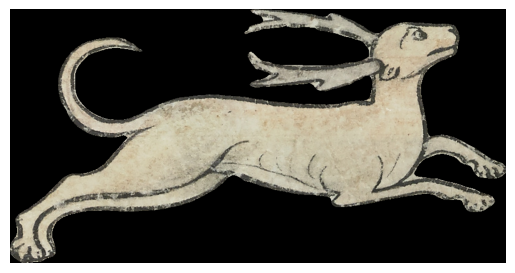

In [ ]:
## illustration of example:
sample = roi_data[0]
print(sample["img_name"])
print("EN:", sample["labels"]["keywords_en"])
print("FR:", sample["labels"]["keywords_fr"])

import matplotlib.pyplot as plt
plt.imshow(cv2.cvtColor(sample["roi_img"], cv2.COLOR_BGR2RGB))
plt.axis("off")

## clip

In [12]:
import torch
import clip
from PIL import Image
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"

model, preprocess = clip.load("ViT-B/32", device=device)
model.eval()

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [22]:
def build_prompts(labels):
    prompts = []
    for l in labels:
        prompts.append(f"a medieval manuscript illustration of an animal {l}")
    return prompts


def roi_to_clip_input(roi_img):
    roi_rgb = roi_img[:, :, ::-1]  # BGR → RGB
    pil_img = Image.fromarray(roi_rgb)
    return preprocess(pil_img).unsqueeze(0)


import torch.nn.functional as F
def clip_match_roi(roi_img, labels):
    """
    roi_img: numpy image
    labels: list[str]
    """
    # 1. prompts
    prompts = build_prompts(labels)

    # 2. encode image
    image_input = roi_to_clip_input(roi_img).to(device)
    with torch.no_grad():
        image_feat = model.encode_image(image_input)
        image_feat = F.normalize(image_feat, dim=-1)

    # 3. encode text
    text_tokens = clip.tokenize(prompts).to(device)
    with torch.no_grad():
        text_feat = model.encode_text(text_tokens)
        text_feat = F.normalize(text_feat, dim=-1)

    # 4. similarity
    sims = (image_feat @ text_feat.T).squeeze(0)  # [num_labels]

    # 5. raw sim
    scores = sims.cpu().numpy()
    results = []
    for label, score in zip(labels, scores):
        results.append({
            "label": label,
            "score": float(score)
        })

    # 排序
    results = sorted(results, key=lambda x: x["score"], reverse=True)
    return results


def build_en_fr_map(keywords_en, mots_cles):
    """
    构建 english → french 的映射
    """
    en_fr = {}
    for en, fr in zip(keywords_en, mots_cles):
        en_fr[en] = fr
    return en_fr


def clip_match_best_label(roi_img, labels_en, threshold=0.3):
    """
    返回：
    - (label, score) 如果通过阈值
    - (None, score) 如果不通过
    """
    results = clip_match_roi(roi_img, labels_en)
    best = results[0]  # 已排序

    if best["score"] < threshold:
        return None, best["score"]

    return best["label"], best["score"]


def draw_contours_with_label(img, contours_list, label, score):
    """在图上画半透明填充 + 边框 + 标签"""
    color = (255, 100, 100)  # 亮蓝色 BGR
    alpha = 0.4

    overlay = img.copy()
    for contour in contours_list:
        cnt_np = np.array(contour, dtype=np.int32).reshape(-1,1,2)
        cv2.drawContours(overlay, [cnt_np], -1, color, thickness=-1)
    cv2.addWeighted(overlay, alpha, img, 1 - alpha, 0, img)

    # 边框
    for contour in contours_list:
        cnt_np = np.array(contour, dtype=np.int32).reshape(-1,1,2)
        cv2.drawContours(img, [cnt_np], -1, (255,255,255), 2)

    # 在轮廓中心写法文 + 分数
    cnt_all = np.vstack([np.array(c, dtype=np.int32) for c in contours_list])
    M = cv2.moments(cnt_all)
    if M['m00'] != 0:
        cx = int(M['m10']/M['m00'])
        cy = int(M['m01']/M['m00'])
        text = f"{label} {score:.2f}"
        cv2.putText(img, text, (cx, cy), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)

In [23]:

VIS_DIR = "../output_clip/vis_clip"
JSON_OUT = "../output_clip/results_clip.json"
os.makedirs(VIS_DIR, exist_ok=True)

final_results = {}
for img_name, masks in sam_dict.items():
    img_path = os.path.join(IMAGE_DIR, img_name)
    img = cv2.imread(img_path)
    if img is None:
        continue

    final_results[img_name] = []

    # 只取属于当前图像的 ROI
    rois_img = [r for r in roi_data if r["img_name"] == img_name]

    for roi in rois_img:
        keywords_en = roi["labels"]["keywords_en"]
        mots_cles = roi["labels"]["keywords_fr"]

        if not keywords_en:
            continue

        # 找到对应 contour（这一步必须在前面）
        mask_info = next(
            m for m in sam_dict[img_name]
            if m["mask_id"] == roi["roi_id"]
        )

        # 英 → 法映射
        en_fr_map = build_en_fr_map(keywords_en, mots_cles)
              
        # CLIP + threshold
        best_en, score = clip_match_best_label(
            roi["roi_img"],
            keywords_en,
            threshold=0.2
        )

        
        # --------- 匹配成功 ----------
        if best_en is not None:
            best_fr = en_fr_map.get(best_en, best_en)

            draw_contours_with_label(
                img,
                mask_info["contours"],
                best_fr,
                score
            )
            
            final_results[img_name].append({
            "roi_id": int(roi["roi_id"]),
            "bbox": [int(x) for x in roi["bbox"]],
            "label_en": best_en,
            "label_fr": best_fr,
            "score": float(score)
        })

        
        # --------- 未匹配 ----------
        else:
            draw_contours_with_label(
                img,
                mask_info["contours"],
                label="unk",   
                score=0
            )

            final_results[img_name].append({
                "roi_id": int(roi["roi_id"]),
                "bbox": [int(x) for x in roi["bbox"]],
                "label_en": "unk",
                "label_fr": "unk",
                "score": 0.0
            })


    # 保存图片
    out_img_path = os.path.join(VIS_DIR, img_name)
    cv2.imwrite(out_img_path, img)

In [20]:
final_results

{'10r.JPG': [{'roi_id': 0,
   'bbox': [733, 1788, 1638, 2251],
   'label_en': 'reindeer',
   'label_fr': 'renne',
   'score': 0.286258727312088},
  {'roi_id': 1,
   'bbox': [208, 1111, 1116, 1681],
   'label_en': 'tiger',
   'label_fr': 'tigre',
   'score': 0.2628635764122009},
  {'roi_id': 2,
   'bbox': [733, 1788, 1638, 2251],
   'label_en': 'reindeer',
   'label_fr': 'renne',
   'score': 0.286258727312088},
  {'roi_id': 3,
   'bbox': [208, 1111, 1116, 1681],
   'label_en': 'tiger',
   'label_fr': 'tigre',
   'score': 0.2628635764122009},
  {'roi_id': 4,
   'bbox': [733, 1788, 1638, 2251],
   'label_en': 'reindeer',
   'label_fr': 'renne',
   'score': 0.286258727312088},
  {'roi_id': 5,
   'bbox': [208, 1111, 1116, 1681],
   'label_en': 'tiger',
   'label_fr': 'tigre',
   'score': 0.2628635764122009},
  {'roi_id': 6,
   'bbox': [733, 1788, 1638, 2251],
   'label_en': 'reindeer',
   'label_fr': 'renne',
   'score': 0.286258727312088},
  {'roi_id': 7,
   'bbox': [208, 1111, 1116, 1681]

In [21]:
with open(JSON_OUT, "w", encoding="utf-8") as f:
    json.dump(final_results, f, indent=2, ensure_ascii=False)